In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd 
import torch.nn.functional as F
import math
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm import tqdm
import csv
from sklearn.preprocessing import StandardScaler


cuda = True if torch.cuda.is_available() else False
print(f'Cuda is on: {cuda}')
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Cuda is on: True


In [2]:
os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:2"

In [3]:
class GetData(Dataset):
    
    '''
        Get dataset 
    '''
    
    def __init__(self,X,y):
        self.X = X
        self.y = y
        print(X.shape)
        print(y.shape)
        
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        
        sample = (self.X[idx,:],
                  self.y[idx,:]) #in tuple shape, will be called in training, eval and testing.

            
        return sample


In [4]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(460,2048),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(2048,1024),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(1024,512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(512,256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(256,128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(128,64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(64,4)
        )
        

        
    def forward(self, x):
        x = torch.flatten(x,1)
        output = self.fc(x) 
        
        return output

In [5]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.bn = torch.nn.BatchNorm2d(1)
        self.RNN = torch.nn.LSTM(92,20,num_layers = 1,dropout = 0.1)
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(20,4) 
        )
        
    def forward(self, x):
        
        OHLC = self.bn(x[:,0:4,:].unsqueeze(1)).squeeze(1) # Batch,Feature,Time
        
        Features = x[:,4:,:]
        
        x = torch.cat([OHLC,Features],1)
        
        x = x.permute(2,0,1) # Time, Batch,Feature
        
        output,(hn,cn) = self.RNN(x)#  Time, Batch,Feature
    
        output = self.fc(hn[-1]) ## Last t to linear, featured from 256 to 4
        
        return output


In [6]:
def train(Model,device,train_dl,optimizer,loss_fn = torch.nn.MSELoss()):
    Model.train() 
    for i, (X,y) in enumerate(train_dl):
        X = X.to(device)
        y = y.to(device)        
        
        Model.zero_grad()
        pred = Model(X)
        loss = loss_fn(pred,y)
        loss.backward()
        optimizer.step()
        

In [7]:
def test(Model, device, test_dl,loss_fn = torch.nn.L1Loss()):
    Model.eval()
    test_loss = 0
    with torch.no_grad():
        for (X, y) in test_dl:
            X = X.to(device)
            y = y.to(device)
            
            pred = Model(X)
            loss = loss_fn(pred, y)
            test_loss += loss.item()*X.shape[0]  # sum up batch loss
    test_loss /= len(test_dl.dataset)
    return test_loss
            

### The trivil loss of stocks

In [8]:
    
for stock in ['AAPL','AMZN','GOOG','FB','NFLX','TSLA']:
    file_name = f'{stock}_features.csv'
    ## read data
    with open(file_name) as f:
        data_list = csv.reader(f)
        data = []
        for row in data_list:
            data.append(row)
        f.close()

    data = torch.tensor(np.delete(np.array(data)[1:,2:],4,axis = 1).astype(np.float)).type(torch.float)
    train_size = int(data.shape[0]*0.9)
    trivialMAE = torch.nn.L1Loss()(data[train_size:-1,0:4],data[train_size + 1:,0:4]).item()
    trivialMSE = torch.nn.MSELoss()(data[train_size:-1,0:4],data[train_size + 1:,0:4]).item()
    trivialRMSE = np.sqrt(trivialMSE)

    print(f'trivial prediction of stock {stock} is MAE:{trivialMAE}, MSE:{trivialMSE}, RMSE:{trivialRMSE}')

trivial prediction of stock AAPL is MAE:2.607447624206543, MSE:10.750199317932129, RMSE:3.2787496577098
trivial prediction of stock AMZN is MAE:66.5531234741211, MSE:7931.47900390625, RMSE:89.05885135070096
trivial prediction of stock GOOG is MAE:42.74393844604492, MSE:2973.805419921875, RMSE:54.53260877605137
trivial prediction of stock FB is MAE:4.977031230926514, MSE:47.28628158569336, RMSE:6.87650213303925
trivial prediction of stock NFLX is MAE:9.902342796325684, MSE:339.4368896484375, RMSE:18.423813113697108
trivial prediction of stock TSLA is MAE:28.430259704589844, MSE:1404.7701416015625, RMSE:37.48026336088852


## Mix stocks

##### Load mix data

In [71]:
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy',allow_pickle=True)
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy',allow_pickle= True)
sc = np.load('sc_params.npy')

X_train = torch.tensor(X_train).type(torch.float).permute(0,2,1)
X_test = torch.tensor(X_test).type(torch.float).permute(0,2,1)
y_train = torch.tensor(y_train).type(torch.float)
y_test = torch.tensor(y_test).type(torch.float)

##### Train MLP and LSTM

In [87]:
train_set = GetData(X_train,y_train)
test_set = GetData(X_test,y_test)
train_dl = DataLoader(train_set,batch_size=1024,shuffle=True)
test_dl = DataLoader(test_set,batch_size=512)


#train LSTM
Train_Loss = []
Test_Loss = []

LSTM_Model = LSTM().to(device)

print("Starting Training Loop...")

optimizer = optim.SGD(LSTM_Model.parameters(),lr = .0001,momentum = 0.9)

for epoch in range(2000):
    train(LSTM_Model,device,train_dl,optimizer)
    Train_Loss.append(test(LSTM_Model,device,train_dl))
    Test_Loss.append(test(LSTM_Model,device,test_dl))
    
    
    
    
#train MLP
Train_Loss = []
Test_Loss = []

MLP_Model = MLP().to(device)

print("Starting Training Loop...")

optimizer = optim.Adam(MLP_Model.parameters(),lr = .01)

for epoch in range(2000):
    train(MLP_Model,device,train_dl,optimizer)
    Train_Loss.append(test(MLP_Model,device,train_dl))
    Test_Loss.append(test(MLP_Model,device,test_dl))

torch.Size([2370, 92, 5])
torch.Size([2370, 4])
torch.Size([480, 92, 5])
torch.Size([480, 4])
Starting Training Loop...
Starting Training Loop...


##### Visualization

TSLA LSTM MAE Loss: 141.97362654262977
TSLA LSTM MSE Loss: 27294.959180531463


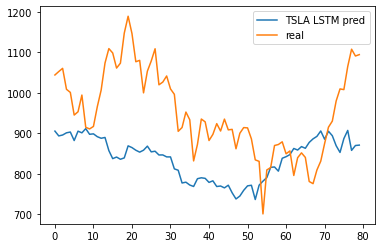

AAPL LSTM MAE Loss: 18.579596521032506
AAPL LSTM MSE Loss: 400.98875515829974


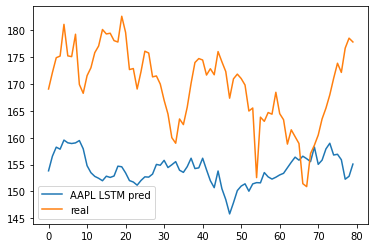

AMZN LSTM MAE Loss: 120.8780637858558
AMZN LSTM MSE Loss: 22898.37527650781


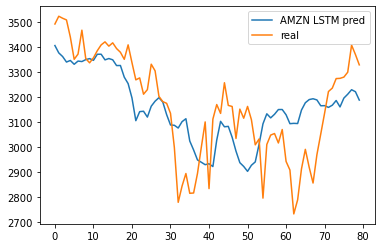

GOOG LSTM MAE Loss: 184.07962252107592
GOOG LSTM MSE Loss: 45047.59482837119


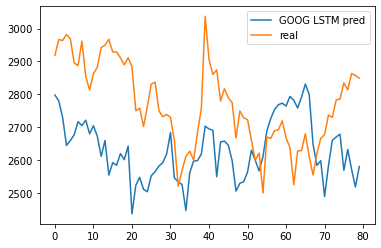

NFLX LSTM MAE Loss: 59.253394859086804
NFLX LSTM MSE Loss: 5270.395396956038


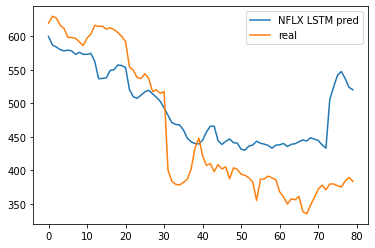

FB LSTM MAE Loss: 32.14823791849821
FB LSTM MSE Loss: 1563.1204122224804


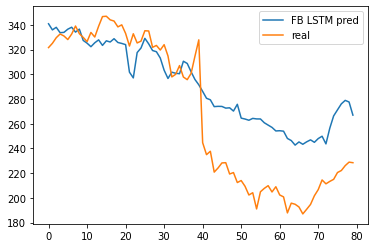

TSLA MLP MAE Loss: 166.58407217764574
TSLA MLP MSE Loss: 32848.39287068363


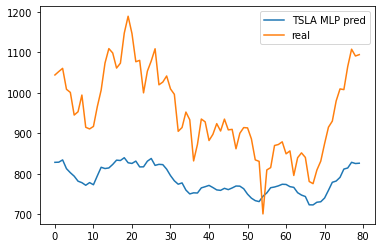

AAPL MLP MAE Loss: 22.618858595371414
AAPL MLP MSE Loss: 537.9966916958108


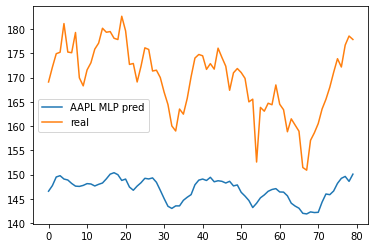

AMZN MLP MAE Loss: 86.73340367237462
AMZN MLP MSE Loss: 10759.573546384421


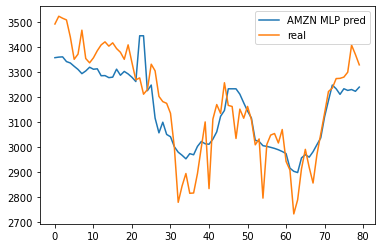

GOOG MLP MAE Loss: 306.1744684860065
GOOG MLP MSE Loss: 100264.77983533878


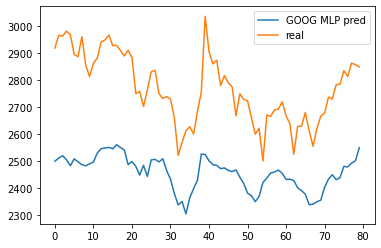

NFLX MLP MAE Loss: 52.07624073734485
NFLX MLP MSE Loss: 3256.729839797498


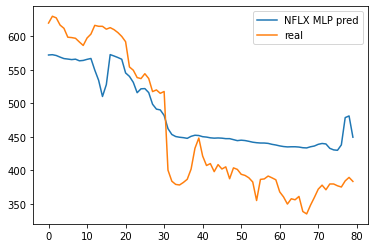

FB MLP MAE Loss: 25.34056888493738
FB MLP MSE Loss: 851.6770093905265


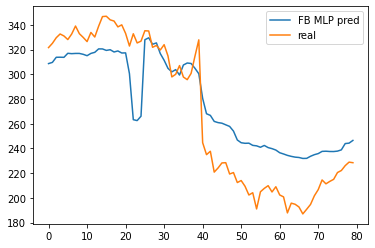

In [136]:
## plot AAPL and print out loss
LSTM_Model.eval()
MLP_Model.eval()

with torch.no_grad():
    X = X_test.to(device)
    y = y_test.to(device)
    
    output = LSTM_Model(X)
    
    TSLApred = []
    TSLAreal = []
    AAPLpred = []
    AAPLreal = []
    AMZNpred = []
    AMZNreal = []
    GOOGpred = []
    GOOGreal = []
    NFLXpred = []
    NFLXreal = []
    FBpred = []
    FBreal = []

    for i in range(X.shape[0]):
        idx = int(X[i,-1,0].item())
        tmp1 = output[i].cpu().numpy()*np.sqrt(sc[idx][1]) + sc[idx][0]
        tmp2 = y[i].cpu().numpy()*np.sqrt(sc[idx][1]) + sc[idx][0]
        if idx == 0:
            TSLApred.append(tmp1)
            TSLAreal.append(tmp2)
        if idx == 1:
            AAPLpred.append(tmp1)
            AAPLreal.append(tmp2)
        if idx == 2:
            AMZNpred.append(tmp1)
            AMZNreal.append(tmp2)
        if idx == 3:
            GOOGpred.append(tmp1)
            GOOGreal.append(tmp2)
            
        if idx == 4:
            NFLXpred.append(tmp1)
            NFLXreal.append(tmp2)
            
        if idx == 5:
            FBpred.append(tmp1)
            FBreal.append(tmp2)
    
    print(f'TSLA LSTM MAE Loss: {np.mean(np.abs(np.array(TSLApred) - np.array(TSLAreal)))}')
    print(f'TSLA LSTM MSE Loss: {np.mean((np.array(TSLApred) - np.array(TSLAreal))**2)}')
    
    plt.plot(np.array(TSLApred)[:,0])
    plt.plot(np.array(TSLAreal)[:,0])
    plt.legend(['TSLA LSTM pred','real'])
    plt.show()
    
    
    print(f'AAPL LSTM MAE Loss: {np.mean(np.abs(np.array(AAPLpred) - np.array(AAPLreal)))}')
    print(f'AAPL LSTM MSE Loss: {np.mean((np.array(AAPLpred) - np.array(AAPLreal))**2)}')
    
    plt.plot(np.array(AAPLpred)[:,0])
    plt.plot(np.array(AAPLreal)[:,0])
    plt.legend(['AAPL LSTM pred','real'])
    plt.show()
    
    
    print(f'AMZN LSTM MAE Loss: {np.mean(np.abs(np.array(AMZNpred) - np.array(AMZNreal)))}')
    print(f'AMZN LSTM MSE Loss: {np.mean((np.array(AMZNpred) - np.array(AMZNreal))**2)}')

    plt.plot(np.array(AMZNpred)[:,0])
    plt.plot(np.array(AMZNreal)[:,0])
    plt.legend(['AMZN LSTM pred','real'])
    plt.show()
    
    
    print(f'GOOG LSTM MAE Loss: {np.mean(np.abs(np.array(GOOGpred) - np.array(GOOGreal)))}')
    print(f'GOOG LSTM MSE Loss: {np.mean((np.array(GOOGpred) - np.array(GOOGreal))**2)}')
    
    plt.plot(np.array(GOOGpred)[:,0])
    plt.plot(np.array(GOOGreal)[:,0])
    plt.legend(['GOOG LSTM pred','real'])
    plt.show()
    
    
    
    print(f'NFLX LSTM MAE Loss: {np.mean(np.abs(np.array(NFLXpred) - np.array(NFLXreal)))}')
    print(f'NFLX LSTM MSE Loss: {np.mean(np.array((NFLXpred) - np.array(NFLXreal))**2)}')
    
    plt.plot(np.array(NFLXpred)[:,0])
    plt.plot(np.array(NFLXreal)[:,0])
    plt.legend(['NFLX LSTM pred','real'])
    plt.show()
    
    
    print(f'FB LSTM MAE Loss: {np.mean(np.abs(np.array(FBpred) - np.array(FBreal)))}')
    print(f'FB LSTM MSE Loss: {np.mean((np.array(FBpred) - np.array(FBreal))**2)}')
    
    plt.plot(np.array(FBpred)[:,0])
    plt.plot(np.array(FBreal)[:,0])
    plt.legend(['FB LSTM pred','real'])
    plt.show()

    
    
    
    output = MLP_Model(X)
    
    TSLApred = []
    TSLAreal = []
    AAPLpred = []
    AAPLreal = []
    AMZNpred = []
    AMZNreal = []
    GOOGpred = []
    GOOGreal = []
    NFLXpred = []
    NFLXreal = []
    FBpred = []
    FBreal = []

    for i in range(X.shape[0]):
        idx = int(X[i,-1,0].item())
        tmp1 = output[i].cpu().numpy()*np.sqrt(sc[idx][1]) + sc[idx][0]
        tmp2 = y[i].cpu().numpy()*np.sqrt(sc[idx][1]) + sc[idx][0]
        
        if idx == 0:
            TSLApred.append(tmp1)
            TSLAreal.append(tmp2)
        if idx == 1:
            AAPLpred.append(tmp1)
            AAPLreal.append(tmp2)
        if idx == 2:
            AMZNpred.append(tmp1)
            AMZNreal.append(tmp2)
        if idx == 3:
            GOOGpred.append(tmp1)
            GOOGreal.append(tmp2)
            
        if idx == 4:
            NFLXpred.append(tmp1)
            NFLXreal.append(tmp2)
            
        if idx == 5:
            FBpred.append(tmp1)
            FBreal.append(tmp2)
    
    print(f'TSLA MLP MAE Loss: {np.mean(np.abs(np.array(TSLApred) - np.array(TSLAreal)))}')
    print(f'TSLA MLP MSE Loss: {np.mean((np.array(TSLApred) - np.array(TSLAreal))**2)}')
    
    plt.plot(np.array(TSLApred)[:,0])
    plt.plot(np.array(TSLAreal)[:,0])
    plt.legend(['TSLA MLP pred','real'])
    plt.show()
    
    
    print(f'AAPL MLP MAE Loss: {np.mean(np.abs(np.array(AAPLpred) - np.array(AAPLreal)))}')
    print(f'AAPL MLP MSE Loss: {np.mean((np.array(AAPLpred) - np.array(AAPLreal))**2)}')
    
    plt.plot(np.array(AAPLpred)[:,0])
    plt.plot(np.array(AAPLreal)[:,0])
    plt.legend(['AAPL MLP pred','real'])
    plt.show()
    
    
    print(f'AMZN MLP MAE Loss: {np.mean(np.abs(np.array(AMZNpred) - np.array(AMZNreal)))}')
    print(f'AMZN MLP MSE Loss: {np.mean((np.array(AMZNpred) - np.array(AMZNreal))**2)}')
    
    plt.plot(np.array(AMZNpred)[:,0])
    plt.plot(np.array(AMZNreal)[:,0])
    plt.legend(['AMZN MLP pred','real'])
    plt.show()
    
    
    print(f'GOOG MLP MAE Loss: {np.mean(np.abs(np.array(GOOGpred) - np.array(GOOGreal)))}')
    print(f'GOOG MLP MSE Loss: {np.mean((np.array(GOOGpred) - np.array(GOOGreal))**2)}')
    
    plt.plot(np.array(GOOGpred)[:,0])
    plt.plot(np.array(GOOGreal)[:,0])
    plt.legend(['GOOG MLP pred','real'])
    plt.show()
    
    
    
    print(f'NFLX MLP MAE Loss: {np.mean(np.abs(np.array(NFLXpred) - np.array(NFLXreal)))}')
    print(f'NFLX MLP MSE Loss: {np.mean((np.array(NFLXpred) - np.array(NFLXreal))**2)}')
    
    plt.plot(np.array(NFLXpred)[:,0])
    plt.plot(np.array(NFLXreal)[:,0])
    plt.legend(['NFLX MLP pred','real'])
    plt.show()
    
    
    print(f'FB MLP MAE Loss: {np.mean(np.abs(np.array(FBpred) - np.array(FBreal)))}')
    print(f'FB MLP MSE Loss: {np.mean((np.array(FBpred) - np.array(FBreal))**2)}')
    
    plt.plot(np.array(FBpred)[:,0])
    plt.plot(np.array(FBreal)[:,0])
    plt.legend(['FB MLP pred','real'])
    plt.show()

# Seperate stock

## AAPL train and visualize

In [9]:
file_name = 'AAPL_features.csv'
## read data
with open(file_name) as f:
    data_list = csv.reader(f)
    data = []
    for row in data_list:
        data.append(row)
    f.close()
    
data = torch.tensor(np.delete(np.array(data)[1:,2:],4,axis = 1).astype(np.float)).type(torch.float)

## coonvert to rate of change
rate = []
for i in range(1,data.shape[0]):
    rate.append((100*(data[i,0:4] - data[i-1,0:4])/data[i-1,0:4]).reshape(1,4))
    
rate = torch.cat(rate)
rate_data = torch.cat([rate,data[1:,4:]],1)
train_size = int(data.shape[0]*0.9)
data_train = rate_data[0:train_size]
data_test = rate_data[train_size-4:]


## train test split
X_train = []
X_test = []
y_train = []
y_test = []
for i in range(data_train.shape[0] - 5):
    X_train.append(data_train[i:i+5].unsqueeze(0))
    y_train.append(data_train[i+5,0:4].unsqueeze(0))
    
for i in range(data_test.shape[0] - 5):
    X_test.append(data_test[i:i+5].unsqueeze(0))
    y_test.append(data_test[i+5,0:4].unsqueeze(0))
    
    
X_train = torch.cat(X_train).permute(0,2,1)
X_test = torch.cat(X_test).permute(0,2,1)
y_train = torch.cat(y_train)
y_test = torch.cat(y_test)
    

train_set = GetData(X_train,y_train)
test_set = GetData(X_test,y_test)
train_dl = DataLoader(train_set,batch_size=1024,shuffle=True)
test_dl = DataLoader(test_set,batch_size=512)


#train LSTM
Train_Loss = []
Test_Loss = []

LSTM_Model = LSTM().to(device)

print("Starting Training Loop...")

optimizer = optim.SGD(LSTM_Model.parameters(),lr = .0001,momentum = 0.9)

for epoch in range(2000):
    train(LSTM_Model,device,train_dl,optimizer)
    Train_Loss.append(test(LSTM_Model,device,train_dl))
    Test_Loss.append(test(LSTM_Model,device,test_dl))
    
    
    
    
#train MLP
Train_Loss = []
Test_Loss = []

MLP_Model = MLP().to(device)

print("Starting Training Loop...")

optimizer = optim.Adam(MLP_Model.parameters(),lr = .01)

for epoch in range(2000):
    train(MLP_Model,device,train_dl,optimizer)
    Train_Loss.append(test(MLP_Model,device,train_dl))
    Test_Loss.append(test(MLP_Model,device,test_dl))

torch.Size([431, 91, 5])
torch.Size([431, 4])
torch.Size([47, 91, 5])
torch.Size([47, 4])


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Starting Training Loop...
Starting Training Loop...


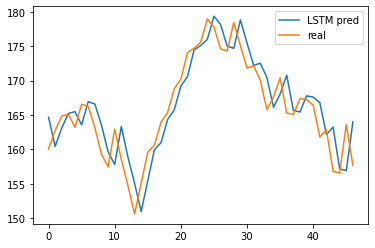

LSTM MAE Loss: 2.791590929031372
LSTM MSE Loss: 11.162666320800781
LSTM RMSE Loss: 3.3410576649918484


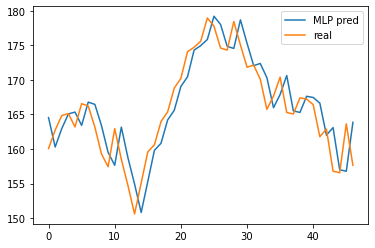

MLP MAE Loss: 2.7797482013702393
MLP MSE Loss: 11.022902488708496
MLP RMSE Loss: 3.320075675147857


In [10]:
## plot AAPL and print out loss
LSTM_Model.eval()
MLP_Model.eval()

with torch.no_grad():
    X = X_test.to(device)
    y = y_test.to(device)
    
    output = LSTM_Model(X)
    
    pred = data[train_size + 1 :-1,3]*0.01*(100+output[:,3]).detach().cpu()
    real = data[train_size + 1 :-1,3]*0.01*(100+y[:,3]).detach().cpu()
    ## convert rate to price
    
    plt.plot(pred)
    plt.plot(real)
    plt.legend(['LSTM pred','real'])
    plt.show()
    
    MAE = torch.nn.L1Loss()(pred,real).item()
    MSE = torch.nn.MSELoss()(pred,real).item()
    RMSE = np.sqrt(MSE)
    print(f'LSTM MAE Loss: {MAE}')
    print(f'LSTM MSE Loss: {MSE}')
    print(f'LSTM RMSE Loss: {RMSE}')
    
    
    
with torch.no_grad():
    X = X_test.to(device)
    y = y_test.to(device)
    
    output = MLP_Model(X)
    
    pred = data[train_size + 1 :-1,3]*0.01*(100+output[:,3]).detach().cpu()
    real = data[train_size + 1 :-1,3]*0.01*(100+y[:,3]).detach().cpu()
    plt.plot(pred)
    plt.plot(real)
    plt.legend(['MLP pred','real'])
    plt.show()
    
    MAE = torch.nn.L1Loss()(pred,real).item()
    MSE = torch.nn.MSELoss()(pred,real).item()
    RMSE = np.sqrt(MSE)
    print(f'MLP MAE Loss: {MAE}')
    print(f'MLP MSE Loss: {MSE}')
    print(f'MLP RMSE Loss: {RMSE}')
    

## AMZN


In [11]:
file_name = 'AMZN_features.csv'
## read data
with open(file_name) as f:
    data_list = csv.reader(f)
    data = []
    for row in data_list:
        data.append(row)
    f.close()
    
data = torch.tensor(np.delete(np.array(data)[1:,2:],4,axis = 1).astype(np.float)).type(torch.float)

## coonvert to rate of change
rate = []
for i in range(1,data.shape[0]):
    rate.append((100*(data[i,0:4] - data[i-1,0:4])/data[i-1,0:4]).reshape(1,4))
    
rate = torch.cat(rate)
rate_data = torch.cat([rate,data[1:,4:]],1)
train_size = int(data.shape[0]*0.9)
data_train = rate_data[0:train_size]
data_test = rate_data[train_size-4:]


## train test split
X_train = []
X_test = []
y_train = []
y_test = []
for i in range(data_train.shape[0] - 5):
    X_train.append(data_train[i:i+5].unsqueeze(0))
    y_train.append(data_train[i+5,0:4].unsqueeze(0))
    
for i in range(data_test.shape[0] - 5):
    X_test.append(data_test[i:i+5].unsqueeze(0))
    y_test.append(data_test[i+5,0:4].unsqueeze(0))
    
    
X_train = torch.cat(X_train).permute(0,2,1)
X_test = torch.cat(X_test).permute(0,2,1)
y_train = torch.cat(y_train)
y_test = torch.cat(y_test)
    

train_set = GetData(X_train,y_train)
test_set = GetData(X_test,y_test)
train_dl = DataLoader(train_set,batch_size=1024,shuffle=True)
test_dl = DataLoader(test_set,batch_size=512)


#train LSTM
Train_Loss = []
Test_Loss = []

LSTM_Model = LSTM().to(device)

print("Starting Training Loop...")

optimizer = optim.SGD(LSTM_Model.parameters(),lr = .0001,momentum = 0.9)

for epoch in range(2000):
    train(LSTM_Model,device,train_dl,optimizer)
    Train_Loss.append(test(LSTM_Model,device,train_dl))
    Test_Loss.append(test(LSTM_Model,device,test_dl))
    
    
    
    
#train MLP
Train_Loss = []
Test_Loss = []

MLP_Model = MLP().to(device)

print("Starting Training Loop...")

optimizer = optim.Adam(MLP_Model.parameters(),lr = .01)

for epoch in range(2000):
    train(MLP_Model,device,train_dl,optimizer)
    Train_Loss.append(test(MLP_Model,device,train_dl))
    Test_Loss.append(test(MLP_Model,device,test_dl))

torch.Size([431, 91, 5])
torch.Size([431, 4])
torch.Size([47, 91, 5])
torch.Size([47, 4])
Starting Training Loop...


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Starting Training Loop...


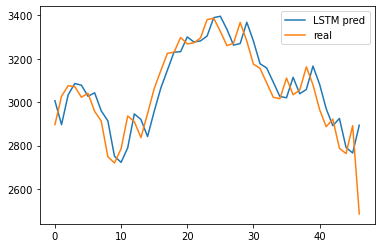

LSTM MAE Loss: 74.57532501220703
LSTM MSE Loss: 9726.1552734375
LSTM RMSE Loss: 98.6212719114771


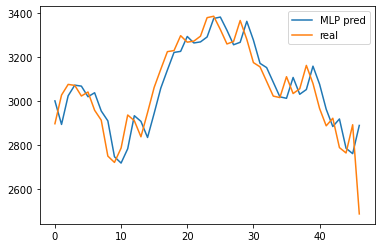

MLP MAE Loss: 74.02979278564453
MLP MSE Loss: 9600.5068359375
MLP RMSE Loss: 97.9821761135029


In [12]:
## plot and print out loss
LSTM_Model.eval()
MLP_Model.eval()

with torch.no_grad():
    X = X_test.to(device)
    y = y_test.to(device)
    
    output = LSTM_Model(X)
    
    pred = data[train_size + 1 :-1,3]*0.01*(100+output[:,3]).detach().cpu()
    real = data[train_size + 1 :-1,3]*0.01*(100+y[:,3]).detach().cpu()
    ## convert rate to price
    
    plt.plot(pred)
    plt.plot(real)
    plt.legend(['LSTM pred','real'])
    plt.show()
    
    MAE = torch.nn.L1Loss()(pred,real).item()
    MSE = torch.nn.MSELoss()(pred,real).item()
    RMSE = np.sqrt(MSE)
    print(f'LSTM MAE Loss: {MAE}')
    print(f'LSTM MSE Loss: {MSE}')
    print(f'LSTM RMSE Loss: {RMSE}')
    
    
    
with torch.no_grad():
    X = X_test.to(device)
    y = y_test.to(device)
    
    output = MLP_Model(X)
    
    pred = data[train_size + 1 :-1,3]*0.01*(100+output[:,3]).detach().cpu()
    real = data[train_size + 1 :-1,3]*0.01*(100+y[:,3]).detach().cpu()
    plt.plot(pred)
    plt.plot(real)
    plt.legend(['MLP pred','real'])
    plt.show()
    
    MAE = torch.nn.L1Loss()(pred,real).item()
    MSE = torch.nn.MSELoss()(pred,real).item()
    RMSE = np.sqrt(MSE)
    print(f'MLP MAE Loss: {MAE}')
    print(f'MLP MSE Loss: {MSE}')
    print(f'MLP RMSE Loss: {RMSE}')

## GOOG


In [13]:
file_name = 'GOOG_features.csv'
## read data
with open(file_name) as f:
    data_list = csv.reader(f)
    data = []
    for row in data_list:
        data.append(row)
    f.close()
    
data = torch.tensor(np.delete(np.array(data)[1:,2:],4,axis = 1).astype(np.float)).type(torch.float)

## coonvert to rate of change
rate = []
for i in range(1,data.shape[0]):
    rate.append((100*(data[i,0:4] - data[i-1,0:4])/data[i-1,0:4]).reshape(1,4))
    
rate = torch.cat(rate)
rate_data = torch.cat([rate,data[1:,4:]],1)
train_size = int(data.shape[0]*0.9)
data_train = rate_data[0:train_size]
data_test = rate_data[train_size-4:]


## train test split
X_train = []
X_test = []
y_train = []
y_test = []
for i in range(data_train.shape[0] - 5):
    X_train.append(data_train[i:i+5].unsqueeze(0))
    y_train.append(data_train[i+5,0:4].unsqueeze(0))
    
for i in range(data_test.shape[0] - 5):
    X_test.append(data_test[i:i+5].unsqueeze(0))
    y_test.append(data_test[i+5,0:4].unsqueeze(0))
    
    
X_train = torch.cat(X_train).permute(0,2,1)
X_test = torch.cat(X_test).permute(0,2,1)
y_train = torch.cat(y_train)
y_test = torch.cat(y_test)
    

train_set = GetData(X_train,y_train)
test_set = GetData(X_test,y_test)
train_dl = DataLoader(train_set,batch_size=1024,shuffle=True)
test_dl = DataLoader(test_set,batch_size=512)


#train LSTM
Train_Loss = []
Test_Loss = []

LSTM_Model = LSTM().to(device)

print("Starting Training Loop...")

optimizer = optim.SGD(LSTM_Model.parameters(),lr = .0001,momentum = 0.9)

for epoch in range(2000):
    train(LSTM_Model,device,train_dl,optimizer)
    Train_Loss.append(test(LSTM_Model,device,train_dl))
    Test_Loss.append(test(LSTM_Model,device,test_dl))
    
    
    
    
#train MLP
Train_Loss = []
Test_Loss = []

MLP_Model = MLP().to(device)

print("Starting Training Loop...")

optimizer = optim.Adam(MLP_Model.parameters(),lr = .01)

for epoch in range(2000):
    train(MLP_Model,device,train_dl,optimizer)
    Train_Loss.append(test(MLP_Model,device,train_dl))
    Test_Loss.append(test(MLP_Model,device,test_dl))

torch.Size([431, 91, 5])
torch.Size([431, 4])
torch.Size([47, 91, 5])
torch.Size([47, 4])
Starting Training Loop...


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Starting Training Loop...


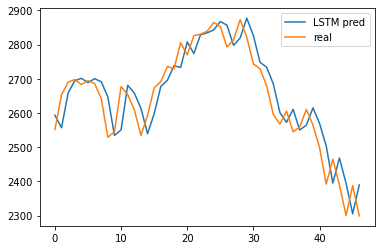

LSTM MAE Loss: 49.802207946777344
LSTM MSE Loss: 3558.888671875
LSTM RMSE Loss: 59.656421882937295


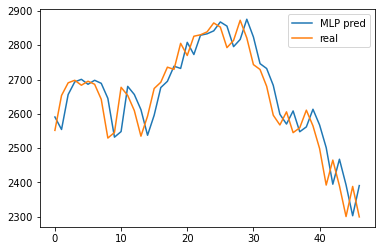

MLP MAE Loss: 49.82023620605469
MLP MSE Loss: 3538.11279296875
MLP RMSE Loss: 59.4820375657118


In [14]:
## plot and print out loss
LSTM_Model.eval()
MLP_Model.eval()

with torch.no_grad():
    X = X_test.to(device)
    y = y_test.to(device)
    
    output = LSTM_Model(X)
    
    pred = data[train_size + 1 :-1,3]*0.01*(100+output[:,3]).detach().cpu()
    real = data[train_size + 1 :-1,3]*0.01*(100+y[:,3]).detach().cpu()
    ## convert rate to price
    
    plt.plot(pred)
    plt.plot(real)
    plt.legend(['LSTM pred','real'])
    plt.show()
    
    MAE = torch.nn.L1Loss()(pred,real).item()
    MSE = torch.nn.MSELoss()(pred,real).item()
    RMSE = np.sqrt(MSE)
    print(f'LSTM MAE Loss: {MAE}')
    print(f'LSTM MSE Loss: {MSE}')
    print(f'LSTM RMSE Loss: {RMSE}')
    
    
    
with torch.no_grad():
    X = X_test.to(device)
    y = y_test.to(device)
    
    output = MLP_Model(X)
    
    pred = data[train_size + 1 :-1,3]*0.01*(100+output[:,3]).detach().cpu()
    real = data[train_size + 1 :-1,3]*0.01*(100+y[:,3]).detach().cpu()
    plt.plot(pred)
    plt.plot(real)
    plt.legend(['MLP pred','real'])
    plt.show()
    
    MAE = torch.nn.L1Loss()(pred,real).item()
    MSE = torch.nn.MSELoss()(pred,real).item()
    RMSE = np.sqrt(MSE)
    print(f'MLP MAE Loss: {MAE}')
    print(f'MLP MSE Loss: {MSE}')
    print(f'MLP RMSE Loss: {RMSE}')

## META (FB)

In [15]:
file_name = 'FB_features.csv'
## read data
with open(file_name) as f:
    data_list = csv.reader(f)
    data = []
    for row in data_list:
        data.append(row)
    f.close()
    
data = torch.tensor(np.delete(np.array(data)[1:,2:],4,axis = 1).astype(np.float)).type(torch.float)

## coonvert to rate of change
rate = []
for i in range(1,data.shape[0]):
    rate.append((100*(data[i,0:4] - data[i-1,0:4])/data[i-1,0:4]).reshape(1,4))
    
rate = torch.cat(rate)
rate_data = torch.cat([rate,data[1:,4:]],1)
train_size = int(data.shape[0]*0.9)
data_train = rate_data[0:train_size]
data_test = rate_data[train_size-4:]


## train test split
X_train = []
X_test = []
y_train = []
y_test = []
for i in range(data_train.shape[0] - 5):
    X_train.append(data_train[i:i+5].unsqueeze(0))
    y_train.append(data_train[i+5,0:4].unsqueeze(0))
    
for i in range(data_test.shape[0] - 5):
    X_test.append(data_test[i:i+5].unsqueeze(0))
    y_test.append(data_test[i+5,0:4].unsqueeze(0))
    
    
X_train = torch.cat(X_train).permute(0,2,1)
X_test = torch.cat(X_test).permute(0,2,1)
y_train = torch.cat(y_train)
y_test = torch.cat(y_test)
    

train_set = GetData(X_train,y_train)
test_set = GetData(X_test,y_test)
train_dl = DataLoader(train_set,batch_size=1024,shuffle=True)
test_dl = DataLoader(test_set,batch_size=512)


#train LSTM
Train_Loss = []
Test_Loss = []

LSTM_Model = LSTM().to(device)

print("Starting Training Loop...")

optimizer = optim.SGD(LSTM_Model.parameters(),lr = .0001,momentum = 0.9)

for epoch in range(2000):
    train(LSTM_Model,device,train_dl,optimizer)
    Train_Loss.append(test(LSTM_Model,device,train_dl))
    Test_Loss.append(test(LSTM_Model,device,test_dl))
    
    
    
    
#train MLP
Train_Loss = []
Test_Loss = []

MLP_Model = MLP().to(device)

print("Starting Training Loop...")

optimizer = optim.Adam(MLP_Model.parameters(),lr = .01)

for epoch in range(2000):
    train(MLP_Model,device,train_dl,optimizer)
    Train_Loss.append(test(MLP_Model,device,train_dl))
    Test_Loss.append(test(MLP_Model,device,test_dl))

torch.Size([431, 91, 5])
torch.Size([431, 4])
torch.Size([47, 91, 5])
torch.Size([47, 4])
Starting Training Loop...


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Starting Training Loop...


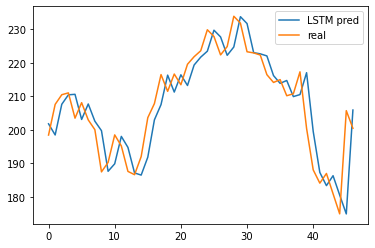

LSTM MAE Loss: 5.609145164489746
LSTM MSE Loss: 57.36553192138672
LSTM RMSE Loss: 7.574003691667091


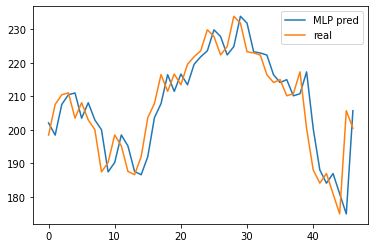

MLP MAE Loss: 5.68539571762085
MLP MSE Loss: 58.31108856201172
MLP RMSE Loss: 7.636169757280919


In [16]:
## plot AAPL and print out loss
LSTM_Model.eval()
MLP_Model.eval()

with torch.no_grad():
    X = X_test.to(device)
    y = y_test.to(device)
    
    output = LSTM_Model(X)
    
    pred = data[train_size + 1 :-1,3]*0.01*(100+output[:,3]).detach().cpu()
    real = data[train_size + 1 :-1,3]*0.01*(100+y[:,3]).detach().cpu()
    ## convert rate to price
    
    plt.plot(pred)
    plt.plot(real)
    plt.legend(['LSTM pred','real'])
    plt.show()
    
    MAE = torch.nn.L1Loss()(pred,real).item()
    MSE = torch.nn.MSELoss()(pred,real).item()
    RMSE = np.sqrt(MSE)
    print(f'LSTM MAE Loss: {MAE}')
    print(f'LSTM MSE Loss: {MSE}')
    print(f'LSTM RMSE Loss: {RMSE}')
    
    
    
with torch.no_grad():
    X = X_test.to(device)
    y = y_test.to(device)
    
    output = MLP_Model(X)
    
    pred = data[train_size + 1 :-1,3]*0.01*(100+output[:,3]).detach().cpu()
    real = data[train_size + 1 :-1,3]*0.01*(100+y[:,3]).detach().cpu()
    plt.plot(pred)
    plt.plot(real)
    plt.legend(['MLP pred','real'])
    plt.show()
    
    MAE = torch.nn.L1Loss()(pred,real).item()
    MSE = torch.nn.MSELoss()(pred,real).item()
    RMSE = np.sqrt(MSE)
    print(f'MLP MAE Loss: {MAE}')
    print(f'MLP MSE Loss: {MSE}')
    print(f'MLP RMSE Loss: {RMSE}')

## NFLX

In [17]:
file_name = 'NFLX_features.csv'
## read data
with open(file_name) as f:
    data_list = csv.reader(f)
    data = []
    for row in data_list:
        data.append(row)
    f.close()
    
data = torch.tensor(np.delete(np.array(data)[1:,2:],4,axis = 1).astype(np.float)).type(torch.float)

## coonvert to rate of change
rate = []
for i in range(1,data.shape[0]):
    rate.append((100*(data[i,0:4] - data[i-1,0:4])/data[i-1,0:4]).reshape(1,4))
    
rate = torch.cat(rate)
rate_data = torch.cat([rate,data[1:,4:]],1)
train_size = int(data.shape[0]*0.9)
data_train = rate_data[0:train_size]
data_test = rate_data[train_size-4:]


## train test split
X_train = []
X_test = []
y_train = []
y_test = []
for i in range(data_train.shape[0] - 5):
    X_train.append(data_train[i:i+5].unsqueeze(0))
    y_train.append(data_train[i+5,0:4].unsqueeze(0))
    
for i in range(data_test.shape[0] - 5):
    X_test.append(data_test[i:i+5].unsqueeze(0))
    y_test.append(data_test[i+5,0:4].unsqueeze(0))
    
    
X_train = torch.cat(X_train).permute(0,2,1)
X_test = torch.cat(X_test).permute(0,2,1)
y_train = torch.cat(y_train)
y_test = torch.cat(y_test)
    

train_set = GetData(X_train,y_train)
test_set = GetData(X_test,y_test)
train_dl = DataLoader(train_set,batch_size=1024,shuffle=True)
test_dl = DataLoader(test_set,batch_size=512)


#train LSTM
Train_Loss = []
Test_Loss = []

LSTM_Model = LSTM().to(device)

print("Starting Training Loop...")

optimizer = optim.SGD(LSTM_Model.parameters(),lr = .0001,momentum = 0.9)

for epoch in range(2000):
    train(LSTM_Model,device,train_dl,optimizer)
    Train_Loss.append(test(LSTM_Model,device,train_dl))
    Test_Loss.append(test(LSTM_Model,device,test_dl))
    
    
    
    
#train MLP
Train_Loss = []
Test_Loss = []

MLP_Model = MLP().to(device)

print("Starting Training Loop...")

optimizer = optim.Adam(MLP_Model.parameters(),lr = .01)

for epoch in range(2000):
    train(MLP_Model,device,train_dl,optimizer)
    Train_Loss.append(test(MLP_Model,device,train_dl))
    Test_Loss.append(test(MLP_Model,device,test_dl))

torch.Size([431, 91, 5])
torch.Size([431, 4])
torch.Size([47, 91, 5])
torch.Size([47, 4])
Starting Training Loop...


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Starting Training Loop...


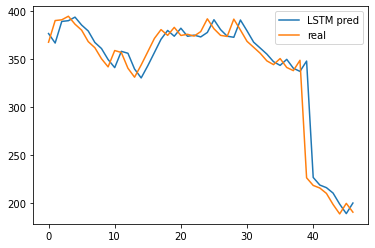

LSTM MAE Loss: 10.951315879821777
LSTM MSE Loss: 409.7200927734375
LSTM RMSE Loss: 20.241543734938734


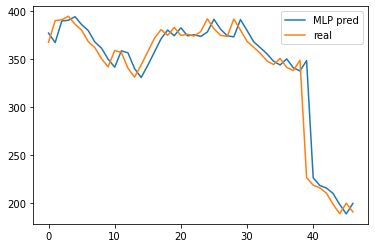

MLP MAE Loss: 10.977991104125977
MLP MSE Loss: 411.0334167480469
MLP RMSE Loss: 20.273959079273265


In [18]:
## plot AAPL and print out loss
LSTM_Model.eval()
MLP_Model.eval()

with torch.no_grad():
    X = X_test.to(device)
    y = y_test.to(device)
    
    output = LSTM_Model(X)
    
    pred = data[train_size + 1 :-1,3]*0.01*(100+output[:,3]).detach().cpu()
    real = data[train_size + 1 :-1,3]*0.01*(100+y[:,3]).detach().cpu()
    ## convert rate to price
    
    plt.plot(pred)
    plt.plot(real)
    plt.legend(['LSTM pred','real'])
    plt.show()
    
    MAE = torch.nn.L1Loss()(pred,real).item()
    MSE = torch.nn.MSELoss()(pred,real).item()
    RMSE = np.sqrt(MSE)
    print(f'LSTM MAE Loss: {MAE}')
    print(f'LSTM MSE Loss: {MSE}')
    print(f'LSTM RMSE Loss: {RMSE}')
    
    
    
with torch.no_grad():
    X = X_test.to(device)
    y = y_test.to(device)
    
    output = MLP_Model(X)
    
    pred = data[train_size + 1 :-1,3]*0.01*(100+output[:,3]).detach().cpu()
    real = data[train_size + 1 :-1,3]*0.01*(100+y[:,3]).detach().cpu()
    plt.plot(pred)
    plt.plot(real)
    plt.legend(['MLP pred','real'])
    plt.show()
    
    MAE = torch.nn.L1Loss()(pred,real).item()
    MSE = torch.nn.MSELoss()(pred,real).item()
    RMSE = np.sqrt(MSE)
    print(f'MLP MAE Loss: {MAE}')
    print(f'MLP MSE Loss: {MSE}')
    print(f'MLP RMSE Loss: {RMSE}')

## TSLA

In [19]:
file_name = 'TSLA_features.csv'
## read data
with open(file_name) as f:
    data_list = csv.reader(f)
    data = []
    for row in data_list:
        data.append(row)
    f.close()
    
data = torch.tensor(np.delete(np.array(data)[1:,2:],4,axis = 1).astype(np.float)).type(torch.float)

## coonvert to rate of change
rate = []
for i in range(1,data.shape[0]):
    rate.append((100*(data[i,0:4] - data[i-1,0:4])/data[i-1,0:4]).reshape(1,4))
    
rate = torch.cat(rate)
rate_data = torch.cat([rate,data[1:,4:]],1)
train_size = int(data.shape[0]*0.9)
data_train = rate_data[0:train_size]
data_test = rate_data[train_size-4:]


## train test split
X_train = []
X_test = []
y_train = []
y_test = []
for i in range(data_train.shape[0] - 5):
    X_train.append(data_train[i:i+5].unsqueeze(0))
    y_train.append(data_train[i+5,0:4].unsqueeze(0))
    
for i in range(data_test.shape[0] - 5):
    X_test.append(data_test[i:i+5].unsqueeze(0))
    y_test.append(data_test[i+5,0:4].unsqueeze(0))
    
    
X_train = torch.cat(X_train).permute(0,2,1)
X_test = torch.cat(X_test).permute(0,2,1)
y_train = torch.cat(y_train)
y_test = torch.cat(y_test)
    

train_set = GetData(X_train,y_train)
test_set = GetData(X_test,y_test)
train_dl = DataLoader(train_set,batch_size=1024,shuffle=True)
test_dl = DataLoader(test_set,batch_size=512)


#train LSTM
Train_Loss = []
Test_Loss = []

LSTM_Model = LSTM().to(device)

print("Starting Training Loop...")

optimizer = optim.SGD(LSTM_Model.parameters(),lr = .0001,momentum = 0.9)

for epoch in range(2000):
    train(LSTM_Model,device,train_dl,optimizer)
    Train_Loss.append(test(LSTM_Model,device,train_dl))
    Test_Loss.append(test(LSTM_Model,device,test_dl))
    
    
    
    
#train MLP
Train_Loss = []
Test_Loss = []

MLP_Model = MLP().to(device)

print("Starting Training Loop...")

optimizer = optim.Adam(MLP_Model.parameters(),lr = .01)

for epoch in range(2000):
    train(MLP_Model,device,train_dl,optimizer)
    Train_Loss.append(test(MLP_Model,device,train_dl))
    Test_Loss.append(test(MLP_Model,device,test_dl))

torch.Size([431, 91, 5])
torch.Size([431, 4])
torch.Size([47, 91, 5])
torch.Size([47, 4])
Starting Training Loop...


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Starting Training Loop...


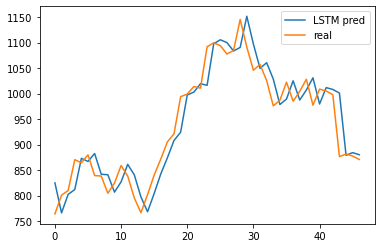

LSTM MAE Loss: 29.499408721923828
LSTM MSE Loss: 1467.6055908203125
LSTM RMSE Loss: 38.309340777678656


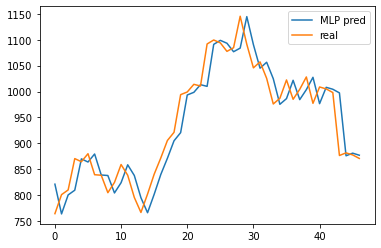

MLP MAE Loss: 29.549705505371094
MLP MSE Loss: 1455.635009765625
MLP RMSE Loss: 38.15278508530701


In [20]:
## plot AAPL and print out loss
LSTM_Model.eval()
MLP_Model.eval()

with torch.no_grad():
    X = X_test.to(device)
    y = y_test.to(device)
    
    output = LSTM_Model(X)
    
    pred = data[train_size + 1 :-1,3]*0.01*(100+output[:,3]).detach().cpu()
    real = data[train_size + 1 :-1,3]*0.01*(100+y[:,3]).detach().cpu()
    ## convert rate to price
    
    plt.plot(pred)
    plt.plot(real)
    plt.legend(['LSTM pred','real'])
    plt.show()
    
    MAE = torch.nn.L1Loss()(pred,real).item()
    MSE = torch.nn.MSELoss()(pred,real).item()
    RMSE = np.sqrt(MSE)
    print(f'LSTM MAE Loss: {MAE}')
    print(f'LSTM MSE Loss: {MSE}')
    print(f'LSTM RMSE Loss: {RMSE}')
    
    
    
with torch.no_grad():
    X = X_test.to(device)
    y = y_test.to(device)
    
    output = MLP_Model(X)
    
    pred = data[train_size + 1 :-1,3]*0.01*(100+output[:,3]).detach().cpu()
    real = data[train_size + 1 :-1,3]*0.01*(100+y[:,3]).detach().cpu()
    plt.plot(pred)
    plt.plot(real)
    plt.legend(['MLP pred','real'])
    plt.show()
    
    MAE = torch.nn.L1Loss()(pred,real).item()
    MSE = torch.nn.MSELoss()(pred,real).item()
    RMSE = np.sqrt(MSE)
    print(f'MLP MAE Loss: {MAE}')
    print(f'MLP MSE Loss: {MSE}')
    print(f'MLP RMSE Loss: {RMSE}')